In [1]:
import torch

torch.__version__

'2.4.0'

In [2]:
train_dir = "data/pizza_sushi_steak/train"
test_dir = "data/pizza_sushi_steak/test"

## manual creation

In [3]:
from torchvision import transforms

manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                        std=[0.229, 0.224, 0.225])
])

In [6]:
import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transform, num_workers=0, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c70c932600>,
 ['pizza', 'steak', 'sushi'])

## auto creation

In [7]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT is the best available weights from pretraining on ImageNet
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transform, num_workers=0, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1c70c932ff0>,
 ['pizza', 'steak', 'sushi'])

## getting pre-trained model

the pre-trained model that we'll be using is from https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html.

paper: https://arxiv.org/abs/1905.11946

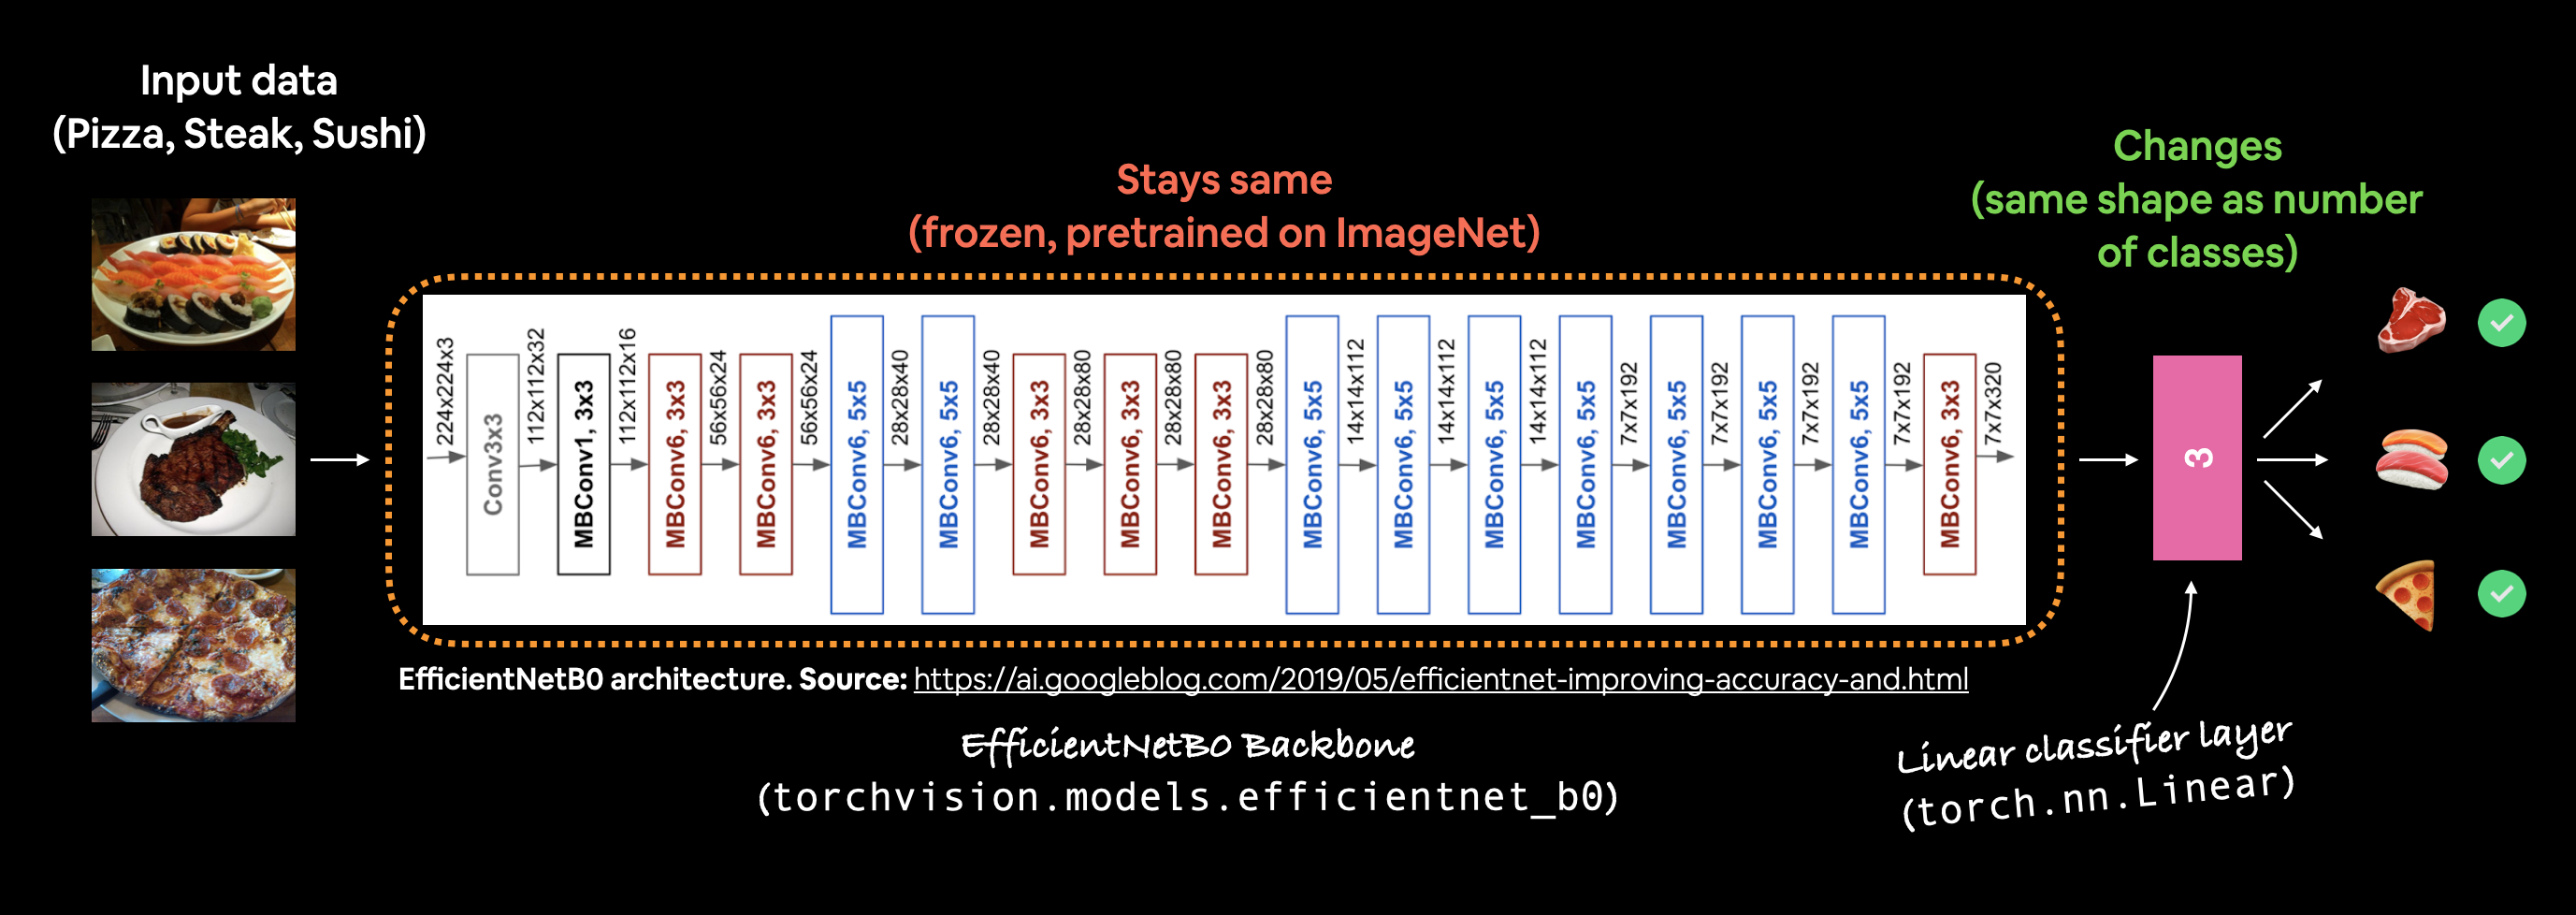

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

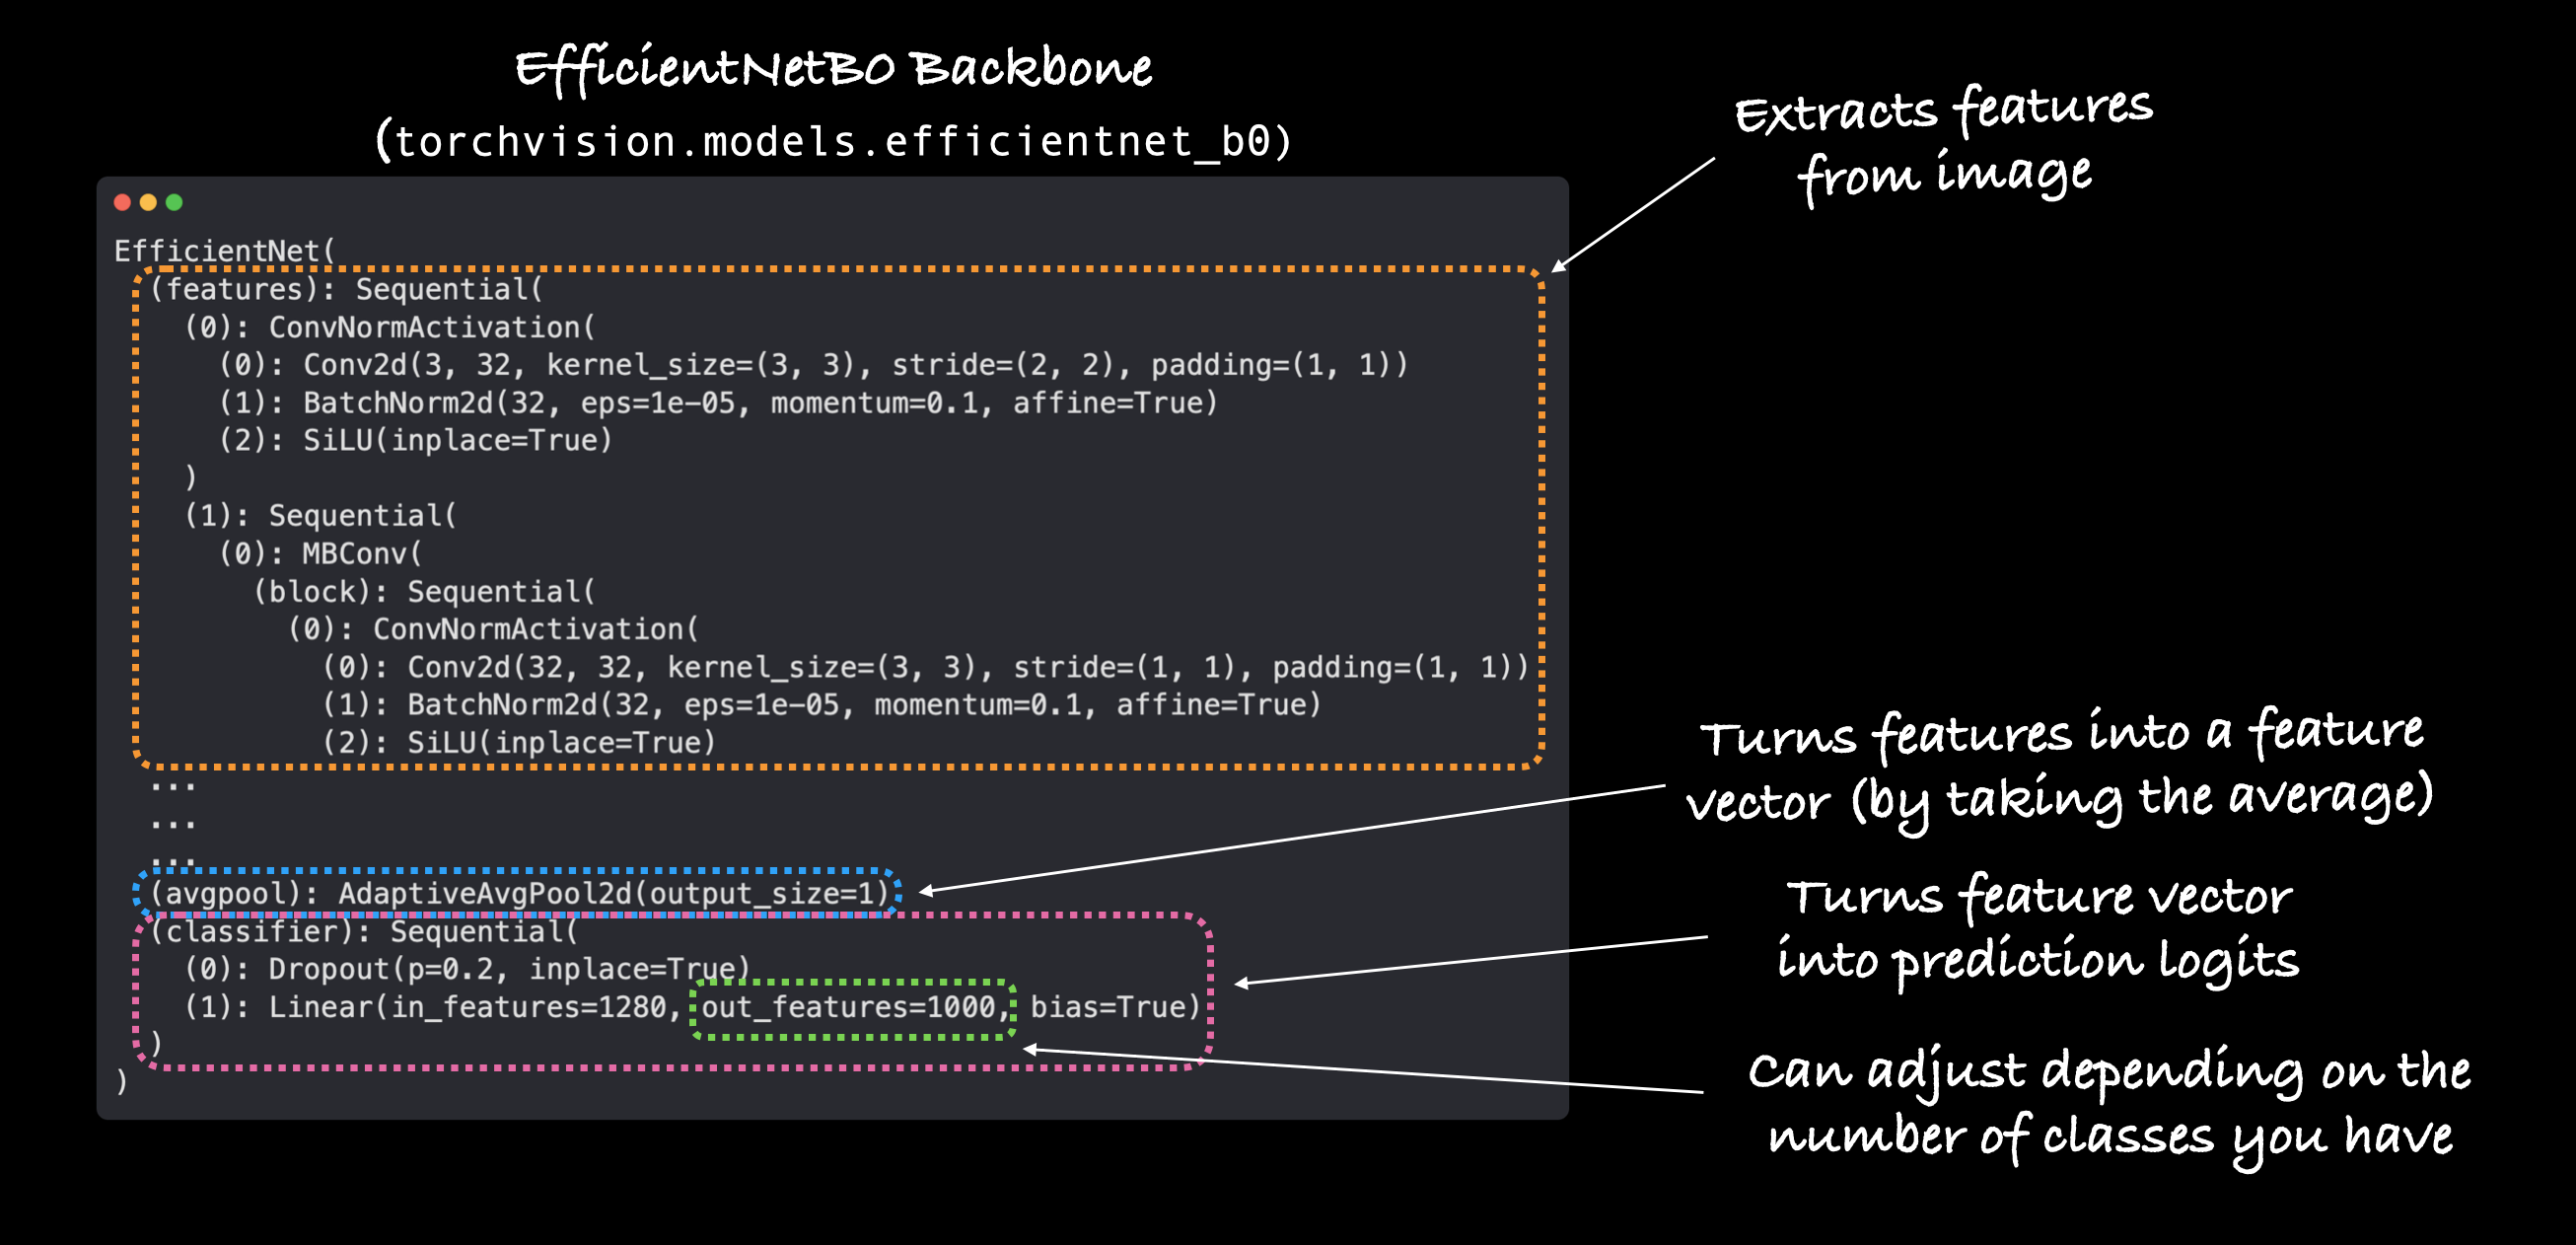

efficientnet_b0 comes in three main parts: 
 1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
 2. `avgpool` - Takes the average of the output of the features layer(s) and turns it into a feature vector.
 3. `classifier` - Turns the feature vector into a vector with the same dimensionality as the number of required output classes **(since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default)**.

In [17]:
from torchinfo import summary

summary(model=model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential: 2-2  

`Note`: Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()`, this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.

## Freezing the base model and chaning the output layer to suit our needs

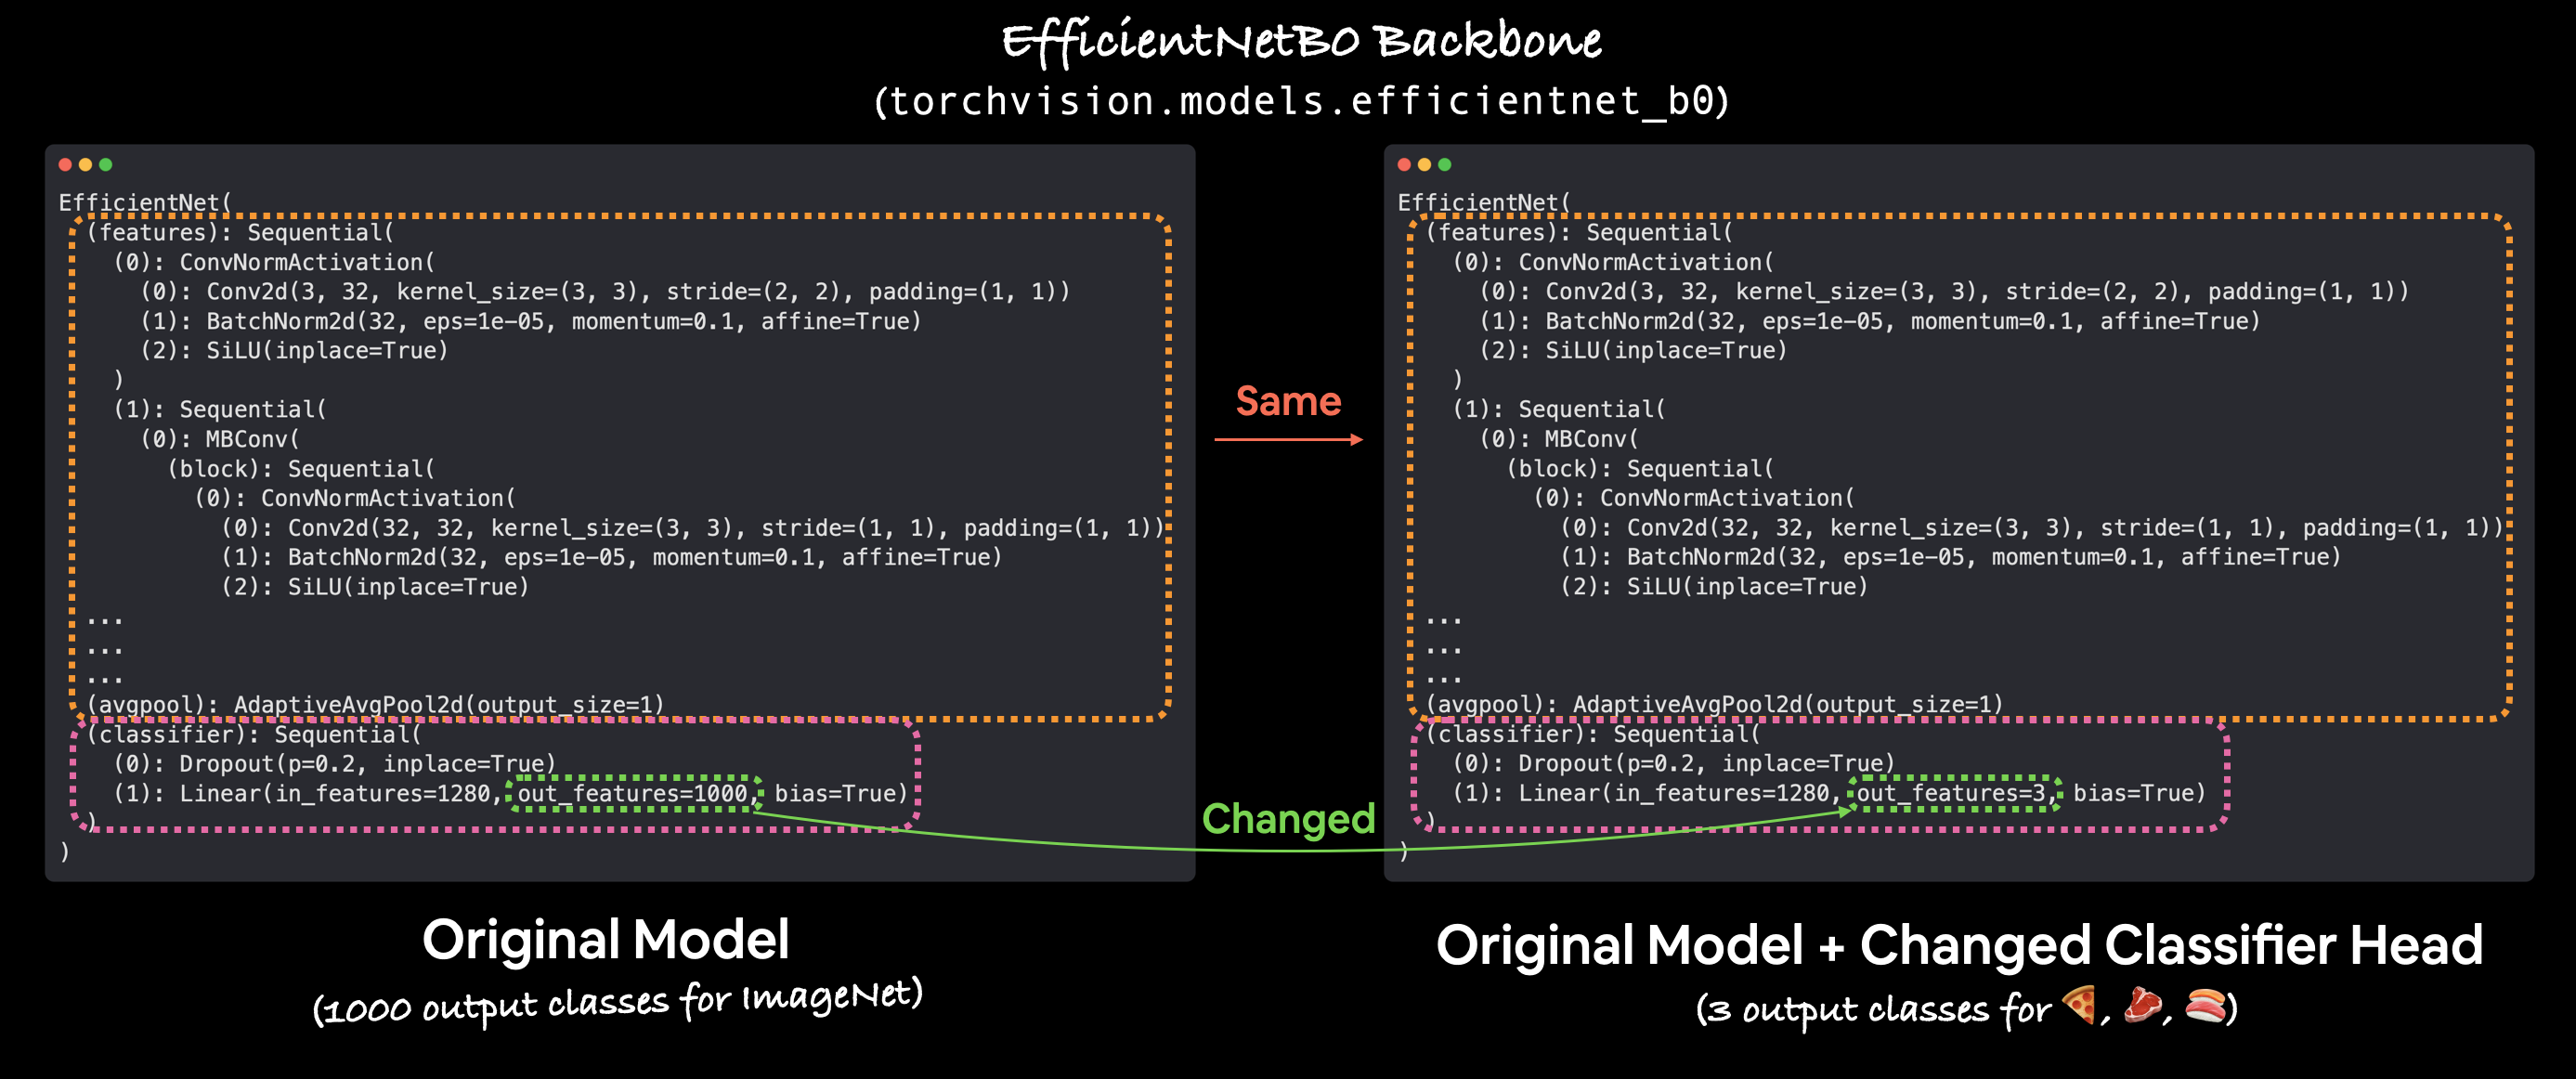

`Note`: To freeze layers means to **keep them how they are during training**. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In [20]:
for param in model.features.parameters():
    param.requires_grad = False

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# change the output layer 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), 
                    bias=True)).to(device)

In [22]:
summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

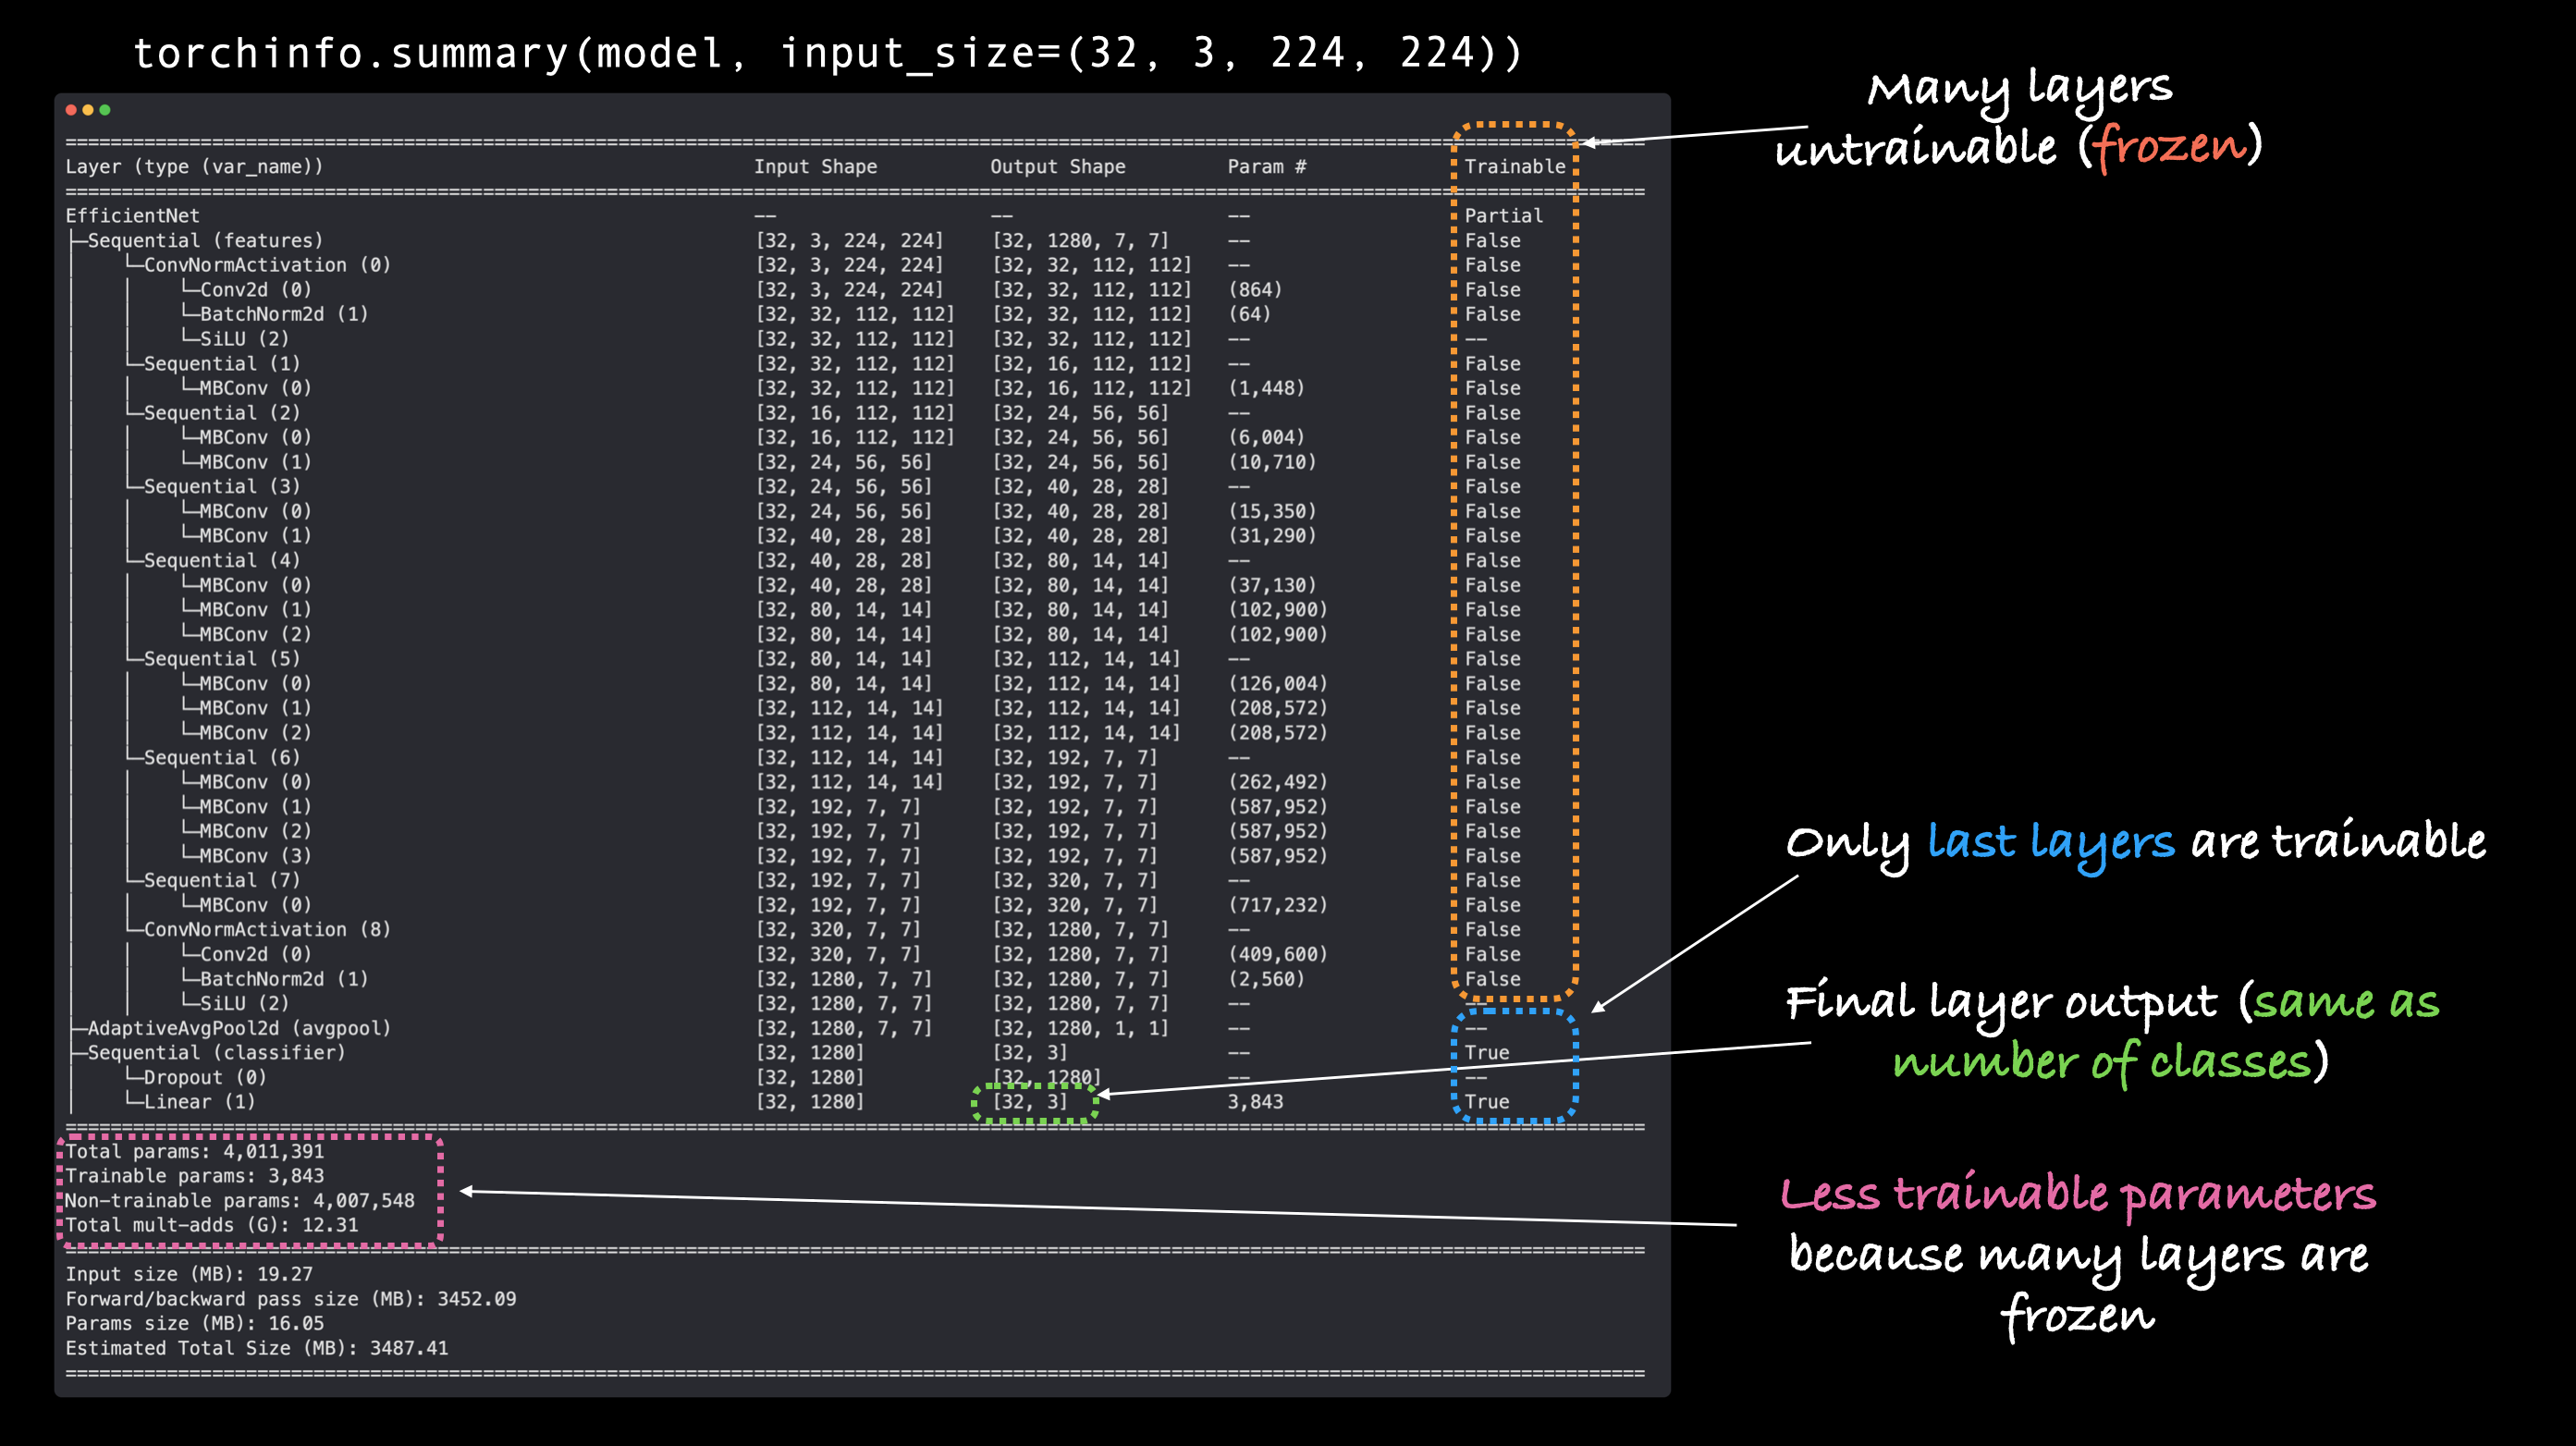

`Note`: **The more trainable parameters a model has, the more compute power/longer it takes to train**. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## train the model

In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
import engine 

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

# setup training and save the results
results = engine.train(model=model, 
                       train_dataloader=train_dataloader, 
                       test_dataloader=test_dataloader, 
                       optimizer=optimizer, 
                       loss_fn=loss_fn, 
                       epochs=5, 
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:04<00:18,  4.58s/it]

Epoch: 1 | train_loss: 0.1723 | train_acc: 0.9729 | test_loss: 0.2706 | test_acc: 0.8943


100%|██████████| 5/5 [00:23<00:00,  4.63s/it]

[INFO] Total training time: 23.148 seconds


In [43]:
results

{'train_loss': [tensor(0.1723, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1669, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1690, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1274, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1551, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.9729166666666667,
  0.96875,
  0.9729166666666667,
  0.98125,
  0.9645833333333333],
 'test_loss': [0.2705620892345905,
  0.2523624747991562,
  0.24577082991600036,
  0.25002181977033616,
  0.2569867059588432],
 'test_acc': [0.8943181818181818,
  0.915909090909091,
  0.9193181818181818,
  0.909659090909091,
  0.9193181818181818]}

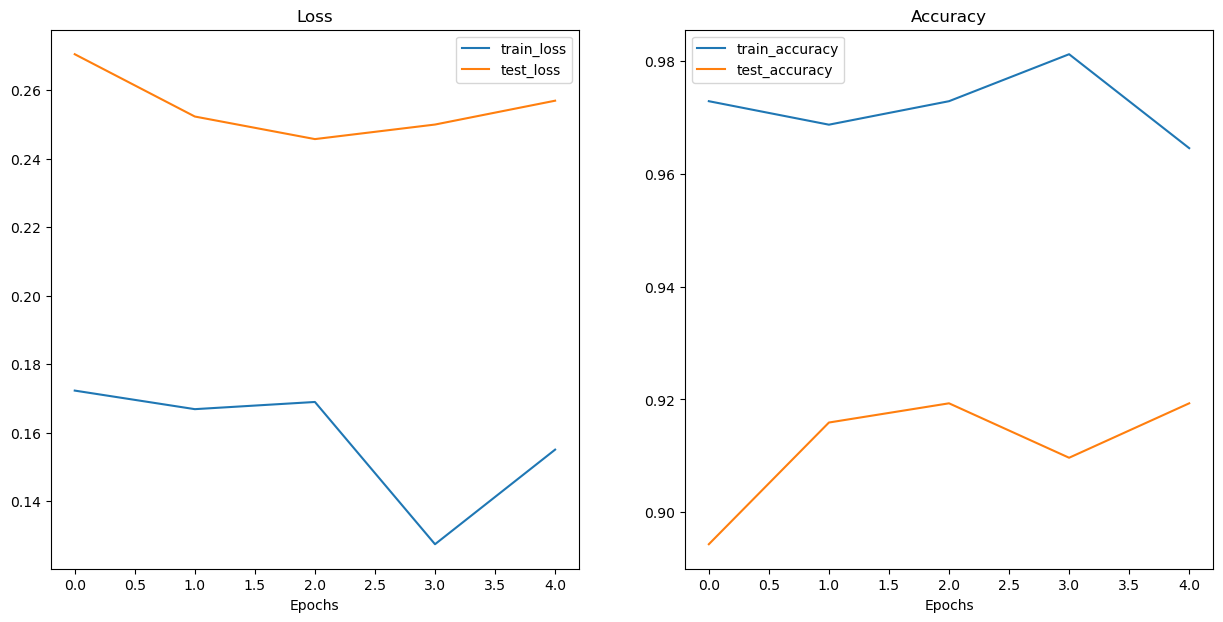

In [49]:
import requests

try:
    from helper_functions import plot_loss_curves
except:
    print("donwloading helper functions")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [186]:
import model_builder

loaded_model = model_builder.create_model_baseline_effnetb0(out_feats=len(class_names), device=device)
loaded_model.load_state_dict(torch.load("models/tinyfood-effnet.pt", weights_only=True))

<All keys matched successfully>

In [187]:
summary(loaded_model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [189]:
!python predict.py -i https://ik.imagekit.io/awwybhhmo/satellite_images/japanese/beyondmenu/hero/16.jpg?tr=w-3840,q-50

sushi | 0.348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [190]:
import torch.utils
from tqdm.auto import tqdm

def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data,
                loss_fn,
                device):   

    loss, accuracy = 0, 0 

    model.eval()
    with torch.inference_mode():
        for X, y  in tqdm(data_loader):
            # send the data to the target device
            X, y = X.to(device), y.to(device) 
            logits = model(X)
            loss += loss_fn(logits, y)
            preds = torch.softmax(logits, dim=-1).argmax(dim=-1)

            accuracy += (preds == y).sum().item()/len(preds)
        
        loss /= len(data_loader)
        accuracy /= len(data_loader)
    
    return{"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_accuracy": accuracy}

In [191]:
model_ori_res = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, device=device)
model_loaded_res = eval_model(model=loaded_model, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


In [192]:
model_loaded_res, model_ori_res

({'model_name': 'EfficientNet',
  'model_loss': 0.3312443494796753,
  'model_accuracy': 0.903409090909091},
 {'model_name': 'EfficientNet',
  'model_loss': 0.25698670744895935,
  'model_accuracy': 0.9193181818181818})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


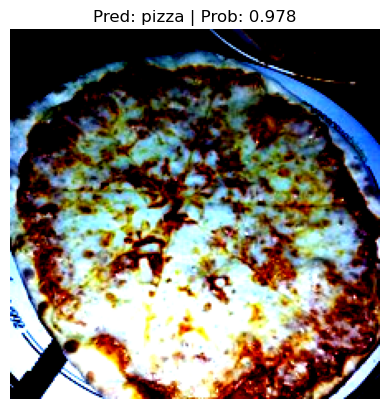

In [203]:
# Get a random list of image paths from test set
import random
from pathlib import Path
from helper_functions import pred_and_plot_image

num_images_to_plot = 1
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=loaded_model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms())

In [219]:
import matplotlib.pyplot as plt
from PIL import Image

def pred_and_plot(model: torch.nn.Module, 
                    image_path: str,
                    transform: transforms.Compose,
                    class_names: list[str] = None):
        model = model.to(device)
        # load image
        img = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
        # setup transformed image 
        transformed_img = transform(img).to(device)
        # forward pass 
        logits = model(transformed_img.unsqueeze(dim=0))
        pred = torch.softmax(logits, dim=-1).argmax(dim=-1)
        # plot the image along with the label 
        plt.imshow(transformed_img.permute(1, 2, 0).cpu())
        title = f"{class_names[pred]} | {torch.softmax(logits, dim=-1).max():.3f}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


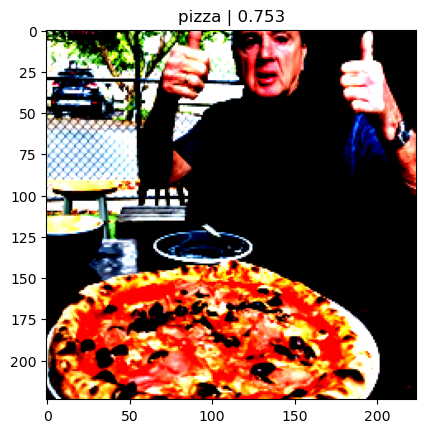

In [227]:
pred_and_plot(model=loaded_model, image_path="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg", 
                transform=weights.transforms(), class_names=class_names)